# Kernel Regression and Kernal SVM in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Kernel (gaussian) Regression

### Derivation

\begin{align*}
\text{Minimize the loss: }& \\
\frac{\partial L(\beta)}{\partial \beta} &= -2X^T(Y-X\beta)+2\lambda\beta = 0 \\
& \Rightarrow \hat{\beta}_{ridge} = (X^TX+\lambda I_p)^{-1}X^TY =  X^T(XX^T+\lambda I_n)^{-1}Y\\
\text{Representer: } \hat{\beta}_{ridge} &= X^T(\langle X, X^T\rangle-\lambda I_n)^{-1}Y\\
	&=  X^TC_{(n \times 1)} = \sum_{j=1}^nc_jX_j, \quad C = (XX^T+\lambda I_n)^{-1}Y \\
\text{Kernel trick: }& \\
f(x) &= h(X)^T\beta = \sum_{k=1}^d\beta_kh_k(X) \\
& \quad \text{where } \beta_k \text{ are implicit parameters of a nonparametric function so } d=\infty\\
L(\beta) &= |Y - h(X)\beta|^2 + \lambda |\beta|^2 \\
& \Rightarrow \hat{\beta}_{kernel} = (h(X)^Th(X)+\lambda I_d)^{-1}h(X)^TY =  h(X)^T(h(X)h(X)^T-\lambda I_n)^{-1}Y \\
& \quad \text{the first expression is not solvable due to infinite dimension while the second is } n \times n \\
\therefore \hat{\beta}_{kernel} &= \sum_{j=1}^n c_j h(X_j), \quad C = (\langle h(X), h(X)\rangle + \lambda I_n)^{-1}Y  = (K(X, X)+ \lambda I_n)^{-1}Y \\
\text{Estimation: }& \\
\hat{f}(x) &= h(x)^T\sum_{j=1}^nc_jh(X_j) =  \sum_{j=1}^n c_j K(X_j, x) \\
\end{align*}

### Experiment

In [2]:
### function for performing kernel ridge regression
def kernel_gaussian(x, y, lamb=0.1, gamma=0.5, x_test=None, y_test=None):
    n = len(y)
    x_matrix = np.array(x)
    y_matrix = np.array(y)
    penalize = np.identity(n)*lamb
    #penalize[0,0] = 0
    k = np.zeros((n, n))
    for i in range(n):
        for j in range(i,n):
            k[i,j] = np.exp(-gamma*np.linalg.norm(x_matrix[i]-x_matrix[j]))
            k[j,i] = k[i,j]
    c = np.dot(np.linalg.inv(k+penalize), y_matrix)
    y_hat = np.dot(k, c.reshape(n,1))
    train_err = np.mean((y_matrix-y_hat)**2)
    if [y_test] != None:
        nt = len(y_test)
        x_test = np.array(x_test)
        y_test = np.array(y_test)
        penalize = np.identity(nt)*lamb
        kt = np.zeros((nt, n))
        for i in range(nt):
            for j in range(n):
                kt[i,j] = np.exp(-gamma*np.linalg.norm(x_test[i]-x_matrix[j]))+(i==j)*lamb
        y_est = np.dot(kt, c.reshape(n,1))
        test_err = np.mean((y_test-y_est)**2)
    return y_hat, train_err, y_est, test_err
# y_hat, train_err, y_est, test_err = kernel_gaussian(x_train, y_train, 0.1, 0.5, x_test, y_test)

100 training observations and 100 testing examples are generated from $y = x_1^2+x_2^2+\epsilon, x \in [0,1]^2, \epsilon \sim N(0,0.1)$. 

In [3]:
### training data
np.random.seed(123)
n = 100
sigma = 0.1
x_train = np.random.uniform(0,1,[n,2])
y_train = np.sum(x_train**2, axis=1)+np.random.normal(0,1,n)*sigma
## testing data
np.random.seed(12345)
n = 100
sigma = 0.1
# x_test = x_train
x_test = np.random.uniform(0,1,[n,2])
y_test = np.sum(x_test**2, axis=1)+np.random.normal(0,1,n)*sigma
# Regulization lambda
lambs = list(np.array(range(101))/20)
lambs = lambs[1:]
# kernal gamma
gammas = [0.05, 0.2, 1, 3, 6, 8, 10, 12]

Firstly, we experiment with a set of 100 $\lambda$s equally spaced within $(0,2]$, using gaussian kernel $exp(-7|x-x'|^2)$. The training error and testing error is displayed in the plot. 

In [4]:
# Run
train_errs = []
test_errs = []
#yhats = []
#ypreds = []
for l in lambs:
    _, train_err, _, test_err = kernel_gaussian(x_train, y_train, l, 7, x_test, y_test)
    train_errs.append(train_err)
    test_errs.append(test_err)
### choose model with the smallest testing error
lamb_optimal = lambs[np.argmin(test_errs)]
lamb_optimal

3.25

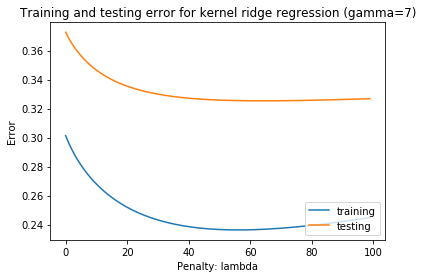

In [5]:
### Plotting
plt.figure(2)
plt.title('Training and testing error for kernel ridge regression (gamma=7)')
plt.xlabel('Penalty: lambda')
plt.ylabel('Error')
plt.plot(train_errs, label='training')
plt.plot(test_errs, label='testing')
plt.legend(loc='lower right')
plt.savefig("1-1.png")

It can be observed that testing error is always higher than that of training. As the amount of penalty $\lambda$ increase, training error keeps increasing, while the testing error decrease and than increase. It indicates that too small $\lambda$ leads to overfitting and too large $\lambda$ leads to underfit, thus there is a bias-variance tradeoff in finding an optimal amount of penalty.

Then, we try different $\gamma$s for the gaussian kernel $exp(-\gamma|x-x'|^2)$, corresponsing training errors and testing errors are displayed in Figure 1-2. For a set of kernels, we plot the learned f(x) in Figure 1-3 as hypersurfaces, and the white surface is the true $f(x)$ from which we generates the training data. 

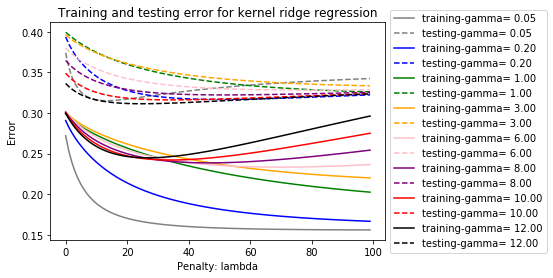

In [6]:
### Plotting
plt.figure(1)
plt.title('Training and testing error for kernel ridge regression')
plt.xlabel('Penalty: lambda')
plt.ylabel('Error')
#plt.xlim(-10, 230)
c = ['grey','b','green','orange','pink','purple','r','k']
ls = []
for g in range(8):
    train_errs = []
    test_errs = []
    for l in lambs:
        _, train_err, _, test_err = kernel_gaussian(x_train, y_train, l, gammas[g], x_test, y_test)
        train_errs.append(train_err)
        test_errs.append(test_err)
        ls.append(lambs[np.argmin(test_errs)])
    plt.plot(train_errs, color=c[g], label="training-gamma= %.2f"%gammas[g])
    plt.plot(test_errs, color=c[g], linestyle='dashed', label="testing-gamma= %.2f"%gammas[g])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("1-2.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

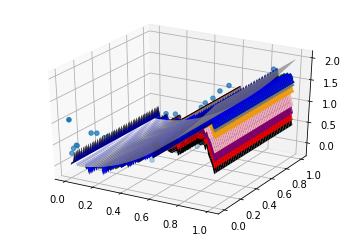

In [7]:
X, Y = x_train[:,0].reshape(100,1), x_train[:,0].reshape(1,100)
x_plot1 = np.linspace(0,1,num=100)
x_plot2 = np.linspace(0,1,num=100)
y_plot = (x_plot1**2+x_plot2**2)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X, Y, y_train.reshape(100,1), label = "true")
ax.plot_surface(x_plot1.reshape(100,1), x_plot2.reshape(1,100), y_plot.reshape(100,1), color = "white")
for i in range(8):
    _, _, ypred, _ = kernel_gaussian(
                x_train, y_train, ls[i], gammas[i], np.concatenate((x_plot1.reshape(100,1), x_plot2.reshape(100,1)), axis=1), y_plot.reshape(100,))
    ax.plot_surface(x_plot1.reshape(100,1), x_plot2.reshape(1,100), ypred.reshape(100,1), color = c[i])
plt.savefig("1-3.png")

For different $\gamma$s, the behavior of testing and training error over against increasing $\lambda$s is similar to that in Figure 1-1, and an ideal $\lambda$ should be around 1. Moreover, as $\gamma$ increases, the distance/dissimilarity measure of the two points is larger, and the hypersurface is more spiky. Either too large or too small $\gamma$ leads to poor performance. In this case, $\gamma=8$ yields the smallest testing error while a smaller $\gamma$ is closer to theoriginal function. It indicates that the learned function with kernel heavily dependent on the training data hence may be not very stable.

## Kernel (gaussian) SVM

### Derivation

\begin{align*}
\text{Minimize the loss: }& \\
L(\beta) &=  \sum_{i=1}^{n} \underset{\alpha_i \in [0,1]}{\max}\alpha_i(1- y_i X_i^\top \beta) + \frac{\lambda}{2} |\beta|^2\\
\text{let } F(\alpha, \beta)&=  \sum_{i=1}^{n}\alpha_i(1- y_i X_i^\top \beta) + \frac{\lambda}{2} |\beta|^2\\
\text{The primal: } \Rightarrow & \text{ the dual: } \\
& \underset{\beta}{\min}[\underset{\alpha_i \in [0,1]}{\max}F(\alpha, \beta)] \Rightarrow
\underset{\alpha_i \in [0,1]}{\max}\underset{\beta}{\min}F(\alpha, \beta) \\
\frac{\partial}{\partial \beta}F(\beta) &= - \sum_{i=1}^{n}\alpha_i y_i X_i + \lambda \beta = 0\\
 &\Rightarrow \text{representer: }\hat{\beta} = \frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i X_i \\
\therefore \ F(\alpha) &= \sum_{i=1}^{n}\alpha_i - \sum_{i=1}^{n}\alpha_iy_i X_i^\top \frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i X_i + \frac{\lambda}{2} | \frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i X_i|^2 \\
&= \sum_{i=1}^{n}\alpha_i - \frac{1}{2\lambda} \sum_{i,j}^{n}\alpha_i \alpha_j y_i y_j \langle X_i, X_j\rangle\\
&=\mathbf{1}^\top \alpha-\frac{1}{2\lambda}\alpha^\top Q \alpha \quad \text{where } Q_{ij} = y_i y_j \langle X_i, X_j\rangle\\
\end{align*}
\begin{align*}
\text{Coordinate descent: } & \quad \alpha^{(t+1)}_i =  \alpha^{(t)}_i + \delta e_i, \ i = 1, 2,..., n\\
q(\alpha) &= \mathbf{1}^\top (\alpha+\delta e_i)-\frac{1}{2\lambda}(\alpha+\delta e_i)^\top Q (\alpha+\delta e_i)\\
		&= \mathbf{1}^\top \alpha-\frac{1}{2\lambda}\alpha^\top Q \alpha + \mathbf{1}^\top(\delta e_i)-\frac{1}{2\lambda}(\delta e_i)^\top Q (\delta e_i)-\frac{1}{\lambda}(\delta e_i)^\top Q \alpha \\
		&= const. +  (\delta e_i)^\top( \mathbf{1} - \frac{1}{\lambda}Q \alpha) - \frac{1}{2\lambda}(\delta e_i)^\top Q (\delta e_i)\\
\frac{\partial}{\partial \delta} &= e_i^\top( \mathbf{1} - \frac{1}{\lambda}Q \alpha) - \frac{1}{\lambda}e_i^\top Q e_i \delta = 0 \Rightarrow \hat{\delta_i} = \frac{(\lambda-Q_i \alpha)}{Q_{ii}}\\
\therefore \ \alpha^{(t+1)}_i &= \alpha^{(t)}_i + \frac{(\lambda-Q_i \alpha)}{Q_{ii}} \\
\text{Kernel trick: } & \quad X \rightarrow h(X)\\
F(\alpha, \beta)&=  \sum_{i=1}^{n}\alpha_i(1- y_i h(X_i)^\top \beta) + \frac{\lambda}{2} |\beta|^2\\
 &\Rightarrow \text{representer: }\hat{\beta} = \frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i h(X_i)\\
 F(\alpha) &= \mathbf{1}^\top \alpha-\frac{1}{2\lambda}\alpha^\top Q \alpha \quad \text{where } Q_{ij} = y_i y_j \langle h(X_i), h(X_j)\rangle =  y_i y_j K(X_i, X_j)\\
 \hat{y} = sign(\hat{f}(x)) &= sign(h(x)^T\frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i h(X_i)) = sign(\frac{1}{\lambda}\sum_{i=1}^{n}\alpha_i y_i K(X_i, x))
\end{align*}

### Experiment

In [8]:
def svm_gaussian(x, y, x_test, y_test, lamb=1, gamma=1, num_iterations=500):
    n = len(y)
    x_train = np.array(x)
    y_train = np.array(y)
    # kernel and Q
    k = np.zeros((n, n))
    q = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            k[i,j] = np.exp(-gamma*np.linalg.norm(x_train[i,:]-x_train[j,:]))
            k[j,i] = k[i,j]
            q[i,j] = y_train[i]*y_train[j]*k[i,j]
            q[j,i] = q[i,j]
    # coordinate descent
    alpha = np.zeros((n))
    #yhat = np.dot((alpha*y_train),k)
    for it in range(num_iterations):
        for i in range(n):
            delta = (lamb-np.dot(q[:,i],alpha))/q[i,i]
            alpha[i] += delta
            if alpha[i] < 0:
                alpha[i] = 0
            elif alpha[i] > 1:
                alpha[i] = 1
            # alpha[i] = (alpha[i]>0)*alpha[i] - (alpha[i]>1)*(alpha[i]-1) # truncation
        #yhat_new = np.dot(k, (alpha*y_train).reshape(n,1))
        if np.abs(delta) < 1e-2:
            break
    # alpha = (alpha>0)*alpha - (alpha>1)*(alpha-1) # truncation
    yhat = np.dot(k, (alpha*y_train).reshape(n,1))/lamb
    y_label = (yhat>=0)*2-1
    train_acc = np.mean(y_label.reshape(n,) == y_train)
    # testing
    nt = len(y_test)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    # kernel
    kt = np.zeros((nt, n))
    for i in range(nt):
        for j in range(n):
            kt[i,j] = np.exp(-gamma*np.linalg.norm(x_train[j,:]-x_test[i,:]))
    ypred = np.dot(kt, (alpha*y_train).reshape(n,1))/lamb
    p_label = (ypred>=0)*2-1
    test_acc = np.mean(p_label.reshape(nt,) == y_test)
    return yhat, train_acc, ypred, test_acc

100 training observations and 100 testing examples are generated from $y = sign(x_1^2+x_2^2-0.8), x \in [0,1]^2$.

In [9]:
### training data
np.random.seed(12345)
n = 100
p = 2
x_train = np.random.uniform(0,1,[n,p])
y_train = (np.sum(x_train**2, axis=1)-0.8>=0)*2-1
### testing data 
np.random.seed(54321)
n = 100
p = 2
x_test = np.random.uniform(0,1,[n,p])
y_test = (np.sum(x_test**2, axis=1)-0.8>=0)*2-1
# Regulization lambda
lambs = list(np.array(range(101))/10)
lambs = lambs[1:]
# kernal gamma
gammas = [0.1, 0.5, 1, 3, 5, 7, 9, 10]

Firstly, we experiment with a set of 100 $\lambda$s equally spaced within $(0,10]$, using gaussian kernel $exp(-5|x-x'|^2)$. The training error and testing accuracy is displayed in Figure 2-1. 

In [10]:
# Run
train_accs1 = []
test_accs1 = []
#yhats = []
#ypreds = []
for l in lambs:
    _, train_acc, _, test_acc = svm_gaussian(x=x_train, y=y_train, x_test=x_test, y_test=y_test, gamma=5, lamb=l)
    train_accs1.append(train_acc)
    test_accs1.append(test_acc)
### choose model with the smallest testing error
lambs[np.argmax(test_accs1)]

0.1

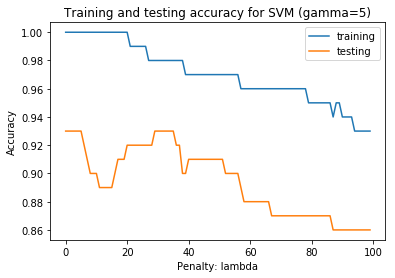

In [11]:
### Plotting
plt.figure(2)
plt.title('Training and testing accuracy for SVM (gamma=5)')
plt.xlabel('Penalty: lambda')
plt.ylabel('Accuracy')
plt.plot(train_accs1, label='training')
plt.plot(test_accs1, label='testing')
plt.legend()
plt.savefig("2-1.png")

It can be observed that training is more accurate than tresting, and the curve is piecewise as in classification task the change in the scores must be large enough to affect the binary classification outcome. As the amount of penalty $\lambda$ increase, the testing accuracy increase and than decrease. It indicates that too small $\lambda$ leads to overfitting and too large $\lambda$ leads to underfit, which again justify the previous disscussion on overfitting.

Then, we try different $\gamma$s for the gaussian kernel $exp(-\gamma|x-x'|^2)$, corresponsing accuracies are displayed in Figure 2-2. For the kernel with the highest accuracy rate (.93), the classification boundary is plotted in Figure 2-3.

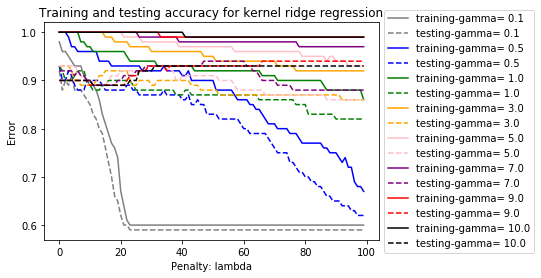

In [12]:
### Plotting
plt.figure(1)
plt.title('Training and testing accuracy for kernel ridge regression')
plt.xlabel('Penalty: lambda')
plt.ylabel('Error')
c = ['grey','b','green','orange','pink','purple','r','k']
for g in range(8):
    train_accs = []
    test_accs = []
    for l in lambs:
        _, train_acc, _, test_acc = svm_gaussian(
                        x=x_train, y=y_train, x_test=x_test, y_test=y_test, gamma=gammas[g], lamb=l)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    plt.plot(train_accs, color=c[g], label="training-gamma= %.1f"%gammas[g])
    plt.plot(test_accs, color=c[g], linestyle='dashed', label="testing-gamma= %.1f"%gammas[g])
lgd = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("2-2.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [19]:
x_plot1 = np.linspace(0, 1, 100)
x_plot2 = np.linspace(0, 1, 100)
x1, x2 = np.meshgrid(x_plot1, x_plot1)
x = np.concatenate((x1.reshape(10000,1), x2.reshape(10000,1)), axis=1)
y_plot = (((x1**2 + x2**2)-1)>0)*2-1
# Run
train_accs7 = []
test_accs7 = []
for l in lambs:
    _, train_acc, _, test_acc = svm_gaussian(x=x_train, y=y_train, x_test=x_test, y_test=y_test, gamma=7, lamb=l)
    train_accs7.append(train_acc)
    test_accs7.append(test_acc)
lamb = lambs[np.argmax(test_accs7)]
y, _, yhat, err = svm_gaussian(x=x_train , y=y_train, x_test=x, y_test=y_plot.reshape(10000,), lamb=lamb, gamma=7)

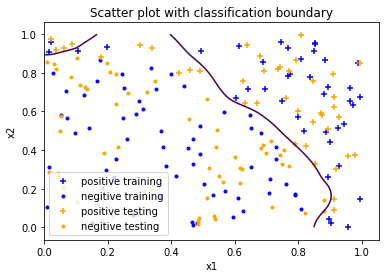

In [20]:
plt.title('Scatter plot with classification boundary')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(x_train[y_train==1,0], x_train[y_train==1,1], c='b', marker="+", label = 'positive training')
plt.scatter(x_train[y_train==-1,0], x_train[y_train==-1,1], c='b', marker=".", label = 'negitive training')
plt.scatter(x_test[y_test==1,0], x_test[y_test==1,1], c='orange', marker="+", label = 'positive testing')
plt.scatter(x_test[y_test==-1,0], x_test[y_test==-1,1], c='orange', marker=".", label = 'negitive testing')
plt.legend()
plt.contour(x1, x2, yhat.reshape(100,100), [0])
plt.savefig("2-3.png")

In Figure 2-2, we can observe that either too small or too large $\gamma$ leads to low accuracy. When $\gamma$ is around 7, the accuracy is the highest which means the resulted hyperplane for classification separated the data points the most clear-cut.